In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [17]:
import warnings
warnings.filterwarnings("ignore")


In [18]:
df = pd.read_csv("Online Retail.csv", encoding="ISO-8859-1")
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  12/01/2010 08:26:00       2.55     17850.0  United Kingdom  
1  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
2  12/01/2010 08:26:00       2.75     17850.0  United Kingdom  
3  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
4  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  


In [19]:
# Remove missing Customer IDs
df = df.dropna(subset=["CustomerID"])

# Remove negative quantity and price (returns/cancellations)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Convert date column
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

print(df.shape)


(397884, 8)


In [20]:
# Create TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Reference date
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [21]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [22]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

print("Explained Variance:", pca.explained_variance_ratio_)


Explained Variance: [0.55502102 0.30249315]


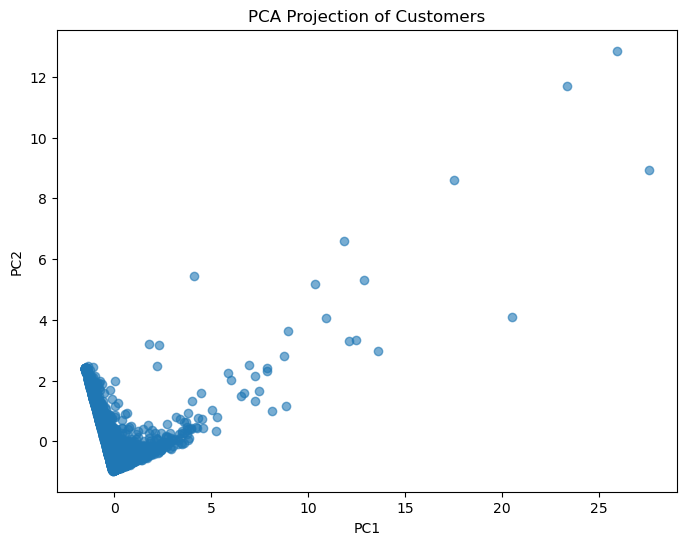

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Customers")
plt.show()


In [24]:
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")


K=2, Silhouette Score=0.560
K=3, Silhouette Score=0.585
K=4, Silhouette Score=0.616
K=5, Silhouette Score=0.617
K=6, Silhouette Score=0.598


In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["KMeans_Cluster"] = kmeans.fit_predict(rfm_scaled)


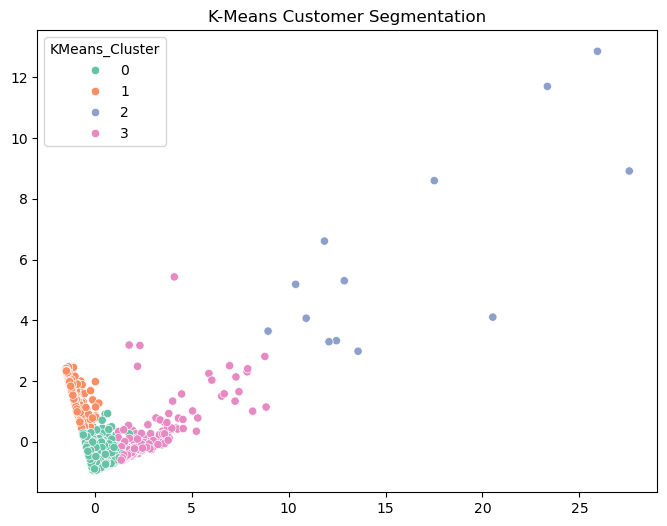

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm_pca[:,0],
    y=rfm_pca[:,1],
    hue=rfm["KMeans_Cluster"],
    palette="Set2"
)
plt.title("K-Means Customer Segmentation")
plt.show()


In [27]:
hier = AgglomerativeClustering(n_clusters=4)
rfm["Hierarchical_Cluster"] = hier.fit_predict(rfm_scaled)


In [28]:
dbscan = DBSCAN(eps=1.2, min_samples=5)
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

print("Noise Customers:", (rfm["DBSCAN_Cluster"] == -1).sum())


Noise Customers: 32


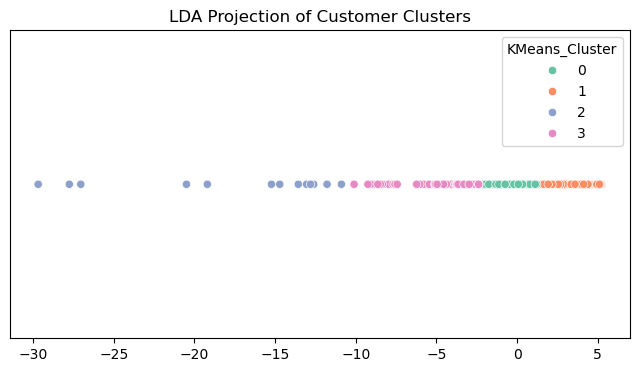

In [29]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda_data = lda.fit_transform(rfm_scaled, rfm["KMeans_Cluster"])

plt.figure(figsize=(8,4))
sns.scatterplot(
    x=lda_data[:,0],
    y=[0]*len(lda_data),
    hue=rfm["KMeans_Cluster"],
    palette="Set2"
)
plt.title("LDA Projection of Customer Clusters")
plt.yticks([])
plt.show()


In [30]:
cluster_summary = rfm.groupby("KMeans_Cluster").mean()
print(cluster_summary)


                   Recency  Frequency       Monetary  Hierarchical_Cluster  \
KMeans_Cluster                                                               
0                43.702685   3.682711    1359.049284              2.000000   
1               248.075914   1.552015     480.617480              2.889410   
2                 7.384615  82.538462  127338.313846              0.615385   
3                15.500000  22.333333   12709.090490              1.500000   

                DBSCAN_Cluster  
KMeans_Cluster                  
0                     0.000000  
1                     0.000000  
2                    -1.000000  
3                    -0.093137  


In [31]:
for cluster in cluster_summary.index:
    print(f"\nCluster {cluster}")
    print(cluster_summary.loc[cluster])

    if cluster_summary.loc[cluster,"Monetary"] > 10000:
        print("→ High-Value Loyal Customers")
    elif cluster_summary.loc[cluster,"Recency"] > 150:
        print("→ Inactive / At-Risk Customers")
    else:
        print("→ Regular / Price-Sensitive Customers")



Cluster 0
Recency                   43.702685
Frequency                  3.682711
Monetary                1359.049284
Hierarchical_Cluster       2.000000
DBSCAN_Cluster             0.000000
Name: 0, dtype: float64
→ Regular / Price-Sensitive Customers

Cluster 1
Recency                 248.075914
Frequency                 1.552015
Monetary                480.617480
Hierarchical_Cluster      2.889410
DBSCAN_Cluster            0.000000
Name: 1, dtype: float64
→ Inactive / At-Risk Customers

Cluster 2
Recency                      7.384615
Frequency                   82.538462
Monetary                127338.313846
Hierarchical_Cluster         0.615385
DBSCAN_Cluster              -1.000000
Name: 2, dtype: float64
→ High-Value Loyal Customers

Cluster 3
Recency                    15.500000
Frequency                  22.333333
Monetary                12709.090490
Hierarchical_Cluster        1.500000
DBSCAN_Cluster             -0.093137
Name: 3, dtype: float64
→ High-Value Loyal Customers
